## Final Project Submission

Please fill out:
* Student name: Daniel Quillao
* Student pace: self paced
* Scheduled project review date/time: TBD
* Instructor name: Jeff Herman
* Blog post URL:


# 1. Import libraries

In [429]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

# 2. Obtain Data

In [338]:
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


# 3. Scrub and Clean Data

### Check Data Types

In [339]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [340]:
# Preview the 5 most frequent entries from each column
for col in df.columns:
    try:
        print(col, df[col].value_counts()[:5])
    except:
        print(col, df[col].value_counts())
        # If there aren't 5+ unique values for a column the first print statement
        # will throw an error for an invalid idx slice
    print('\n') # Break up the output between columns

id 795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
Name: id, dtype: int64


date 6/23/2014    142
6/26/2014    131
6/25/2014    131
7/8/2014     127
4/27/2015    126
Name: date, dtype: int64


price 350000.0    172
450000.0    172
550000.0    159
500000.0    152
425000.0    150
           ... 
870515.0      1
336950.0      1
386100.0      1
176250.0      1
884744.0      1
Name: price, Length: 3622, dtype: int64


bedrooms 3    9824
4    6882
2    2760
5    1601
6     272
Name: bedrooms, dtype: int64


bathrooms 2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
Name: bathrooms, dtype: int64


sqft_living 1300    138
1400    135
1440    133
1660    129
1010    129
Name: sqft_living, dtype: int64


sqft_lot 5000    358
6000    290
4000    251
7200    220
7500    119
Name: sqft_lot, dtype: 

### Check for Erroneous Values (i.e. ?)

In [341]:
# sqft_basement includes 454 instances of '?'
sum(df['sqft_basement'] =='?')

454

In [342]:
# Verify that instances are dropped
sum(df['sqft_basement'] =='?')

454

In [343]:
# Drop rows as it only accounts for 2% of the data
df = df.drop(df[df['sqft_basement']=='?'].index)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21143 non-null  int64  
 1   date           21143 non-null  object 
 2   price          21143 non-null  float64
 3   bedrooms       21143 non-null  int64  
 4   bathrooms      21143 non-null  float64
 5   sqft_living    21143 non-null  int64  
 6   sqft_lot       21143 non-null  int64  
 7   floors         21143 non-null  float64
 8   waterfront     18804 non-null  float64
 9   view           21082 non-null  float64
 10  condition      21143 non-null  int64  
 11  grade          21143 non-null  int64  
 12  sqft_above     21143 non-null  int64  
 13  sqft_basement  21143 non-null  object 
 14  yr_built       21143 non-null  int64  
 15  yr_renovated   17389 non-null  float64
 16  zipcode        21143 non-null  int64  
 17  lat            21143 non-null  float64
 18  long  

### Check for Null Values

In [344]:
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2339
view               61
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3754
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [345]:
# Check waterfront
df['waterfront'].value_counts()

0.0    18662
1.0      142
Name: waterfront, dtype: int64

In [346]:
# Fill NaNs with median (which is 0, the majority of the data)
df['waterfront'].fillna(df['waterfront'].median(), inplace = True)

In [347]:
# Double-check waterfront
df['waterfront'].isna().sum()

0

In [348]:
# Check view
df['view'].value_counts()

0.0    19018
2.0      930
3.0      496
1.0      327
4.0      311
Name: view, dtype: int64

In [349]:
# Drop NaNs (61, small percentage of data)
df.dropna(subset = ['view'], inplace = True)

In [350]:
# Double-check view
df['view'].isna().sum()

0

In [351]:
# Check yr_renovated
df['yr_renovated'].value_counts()

0.0       16618
2014.0       69
2003.0       31
2013.0       31
2007.0       30
          ...  
1953.0        1
1944.0        1
1934.0        1
1971.0        1
1959.0        1
Name: yr_renovated, Length: 69, dtype: int64

In [352]:
# Drop yr_renovated column (large percentage is either 0 (16618) or NaNs (3754))
df.drop('yr_renovated', axis = 1, inplace = True)

In [353]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21082 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21082 non-null  int64  
 1   date           21082 non-null  object 
 2   price          21082 non-null  float64
 3   bedrooms       21082 non-null  int64  
 4   bathrooms      21082 non-null  float64
 5   sqft_living    21082 non-null  int64  
 6   sqft_lot       21082 non-null  int64  
 7   floors         21082 non-null  float64
 8   waterfront     21082 non-null  float64
 9   view           21082 non-null  float64
 10  condition      21082 non-null  int64  
 11  grade          21082 non-null  int64  
 12  sqft_above     21082 non-null  int64  
 13  sqft_basement  21082 non-null  object 
 14  yr_built       21082 non-null  int64  
 15  zipcode        21082 non-null  int64  
 16  lat            21082 non-null  float64
 17  long           21082 non-null  float64
 18  sqft_l

### Numeric Data Encoded as Strings
- sqft_basement

In [354]:
df['sqft_basement'] = pd.to_numeric(df['sqft_basement'])

In [355]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21082 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21082 non-null  int64  
 1   date           21082 non-null  object 
 2   price          21082 non-null  float64
 3   bedrooms       21082 non-null  int64  
 4   bathrooms      21082 non-null  float64
 5   sqft_living    21082 non-null  int64  
 6   sqft_lot       21082 non-null  int64  
 7   floors         21082 non-null  float64
 8   waterfront     21082 non-null  float64
 9   view           21082 non-null  float64
 10  condition      21082 non-null  int64  
 11  grade          21082 non-null  int64  
 12  sqft_above     21082 non-null  int64  
 13  sqft_basement  21082 non-null  float64
 14  yr_built       21082 non-null  int64  
 15  zipcode        21082 non-null  int64  
 16  lat            21082 non-null  float64
 17  long           21082 non-null  float64
 18  sqft_l

### Categorical Data Encoded as Integers
- waterfront, view, zipcode, condition, and grade

In [356]:
convert_to_str = ['waterfront', 'view', 'zipcode', 'condition', 'grade']

for col in convert_to_str:
    df[col] = df[col].astype('str')        

In [357]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21082 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21082 non-null  int64  
 1   date           21082 non-null  object 
 2   price          21082 non-null  float64
 3   bedrooms       21082 non-null  int64  
 4   bathrooms      21082 non-null  float64
 5   sqft_living    21082 non-null  int64  
 6   sqft_lot       21082 non-null  int64  
 7   floors         21082 non-null  float64
 8   waterfront     21082 non-null  object 
 9   view           21082 non-null  object 
 10  condition      21082 non-null  object 
 11  grade          21082 non-null  object 
 12  sqft_above     21082 non-null  int64  
 13  sqft_basement  21082 non-null  float64
 14  yr_built       21082 non-null  int64  
 15  zipcode        21082 non-null  object 
 16  lat            21082 non-null  float64
 17  long           21082 non-null  float64
 18  sqft_l

## Get rid of unecessary features

In [358]:
df.drop(columns=['id', 'date'], inplace=True) 

In [359]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21082 entries, 0 to 21596
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21082 non-null  float64
 1   bedrooms       21082 non-null  int64  
 2   bathrooms      21082 non-null  float64
 3   sqft_living    21082 non-null  int64  
 4   sqft_lot       21082 non-null  int64  
 5   floors         21082 non-null  float64
 6   waterfront     21082 non-null  object 
 7   view           21082 non-null  object 
 8   condition      21082 non-null  object 
 9   grade          21082 non-null  object 
 10  sqft_above     21082 non-null  int64  
 11  sqft_basement  21082 non-null  float64
 12  yr_built       21082 non-null  int64  
 13  zipcode        21082 non-null  object 
 14  lat            21082 non-null  float64
 15  long           21082 non-null  float64
 16  sqft_living15  21082 non-null  int64  
 17  sqft_lot15     21082 non-null  int64  
dtypes: flo

## Explore Data

In [360]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15
count,2.108200e+04,21082.000000,21082.000000,21082.000000,2.108200e+04,21082.00000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000
mean,5.402469e+05,3.372403,2.115916,2080.359975,1.507759e+04,1.49362,1789.000000,291.359975,1971.023337,47.560371,-122.213843,1986.917418,12732.514135
std,3.667323e+05,0.924996,0.768142,917.856396,4.117338e+04,0.53937,828.369355,442.007858,29.323120,0.138568,0.140607,685.544250,27148.781580
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.00000,370.000000,0.000000,1900.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.00000,1200.000000,0.000000,1952.000000,47.471325,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.620000e+03,1.50000,1560.000000,0.000000,1975.000000,47.572200,-122.230000,1840.000000,7626.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.069775e+04,2.00000,2210.000000,560.000000,1997.000000,47.678200,-122.125000,2360.000000,10088.750000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.50000,9410.000000,4820.000000,2015.000000,47.777600,-121.315000,6210.000000,871200.000000


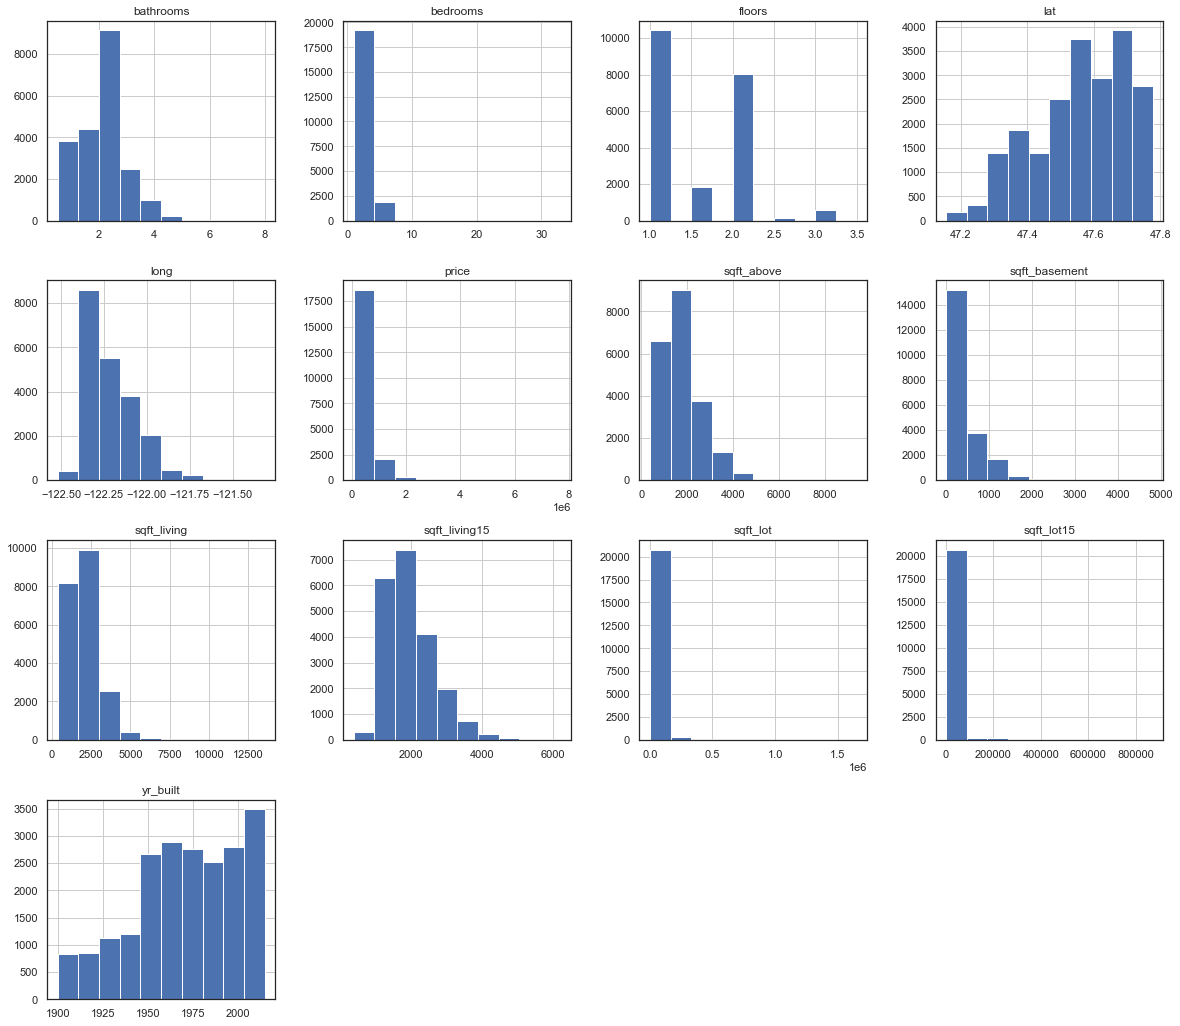

In [361]:
df.hist(figsize = (20,18));

Note how skewed most of these distributions are. While linear regression does not assume that each of the individual predictors are normally distributed, it does assume a linear relationship between the predictors and the target variable

### Check for Linearity

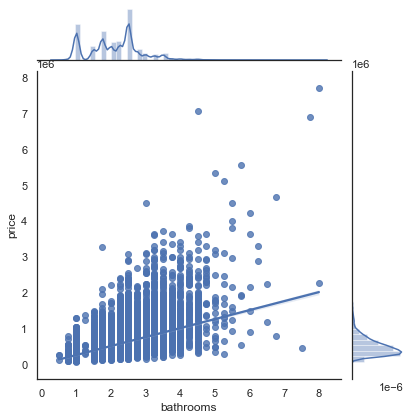

In [362]:
sns.jointplot('bathrooms','price', data=df, kind='reg');

In [363]:
# Comment: There seems to be a some-what linear correlation between num_reviews and list_price
# Though the relationship is noisy

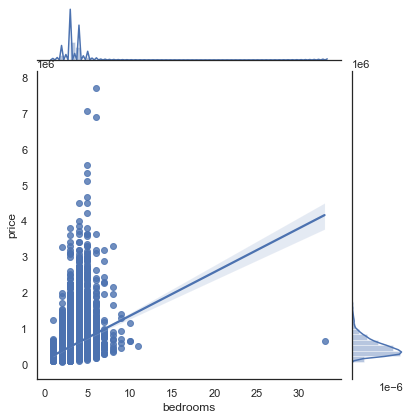

In [364]:
sns.jointplot('bedrooms','price', data=df, kind='reg');

In [365]:
# Not much of a linear relationship

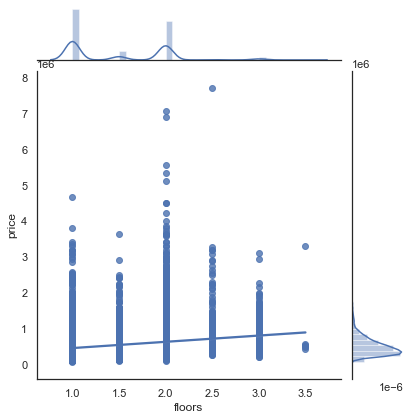

In [366]:
sns.jointplot('floors','price', data=df, kind='reg');

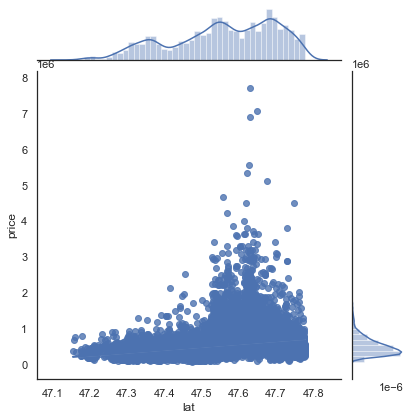

In [367]:
sns.jointplot('lat','price', data=df, kind='reg');

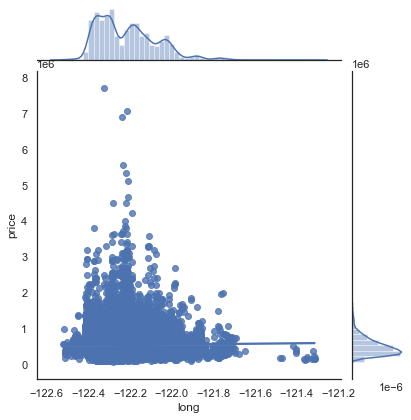

In [368]:
sns.jointplot('long','price', data=df, kind='reg');

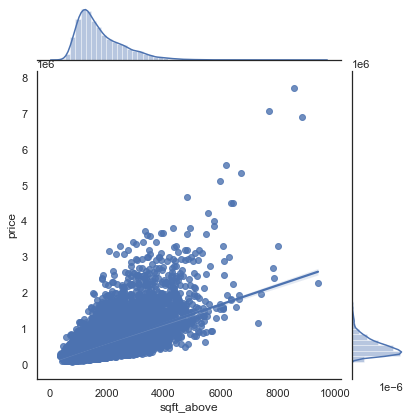

In [369]:
sns.jointplot('sqft_above','price', data=df, kind='reg');

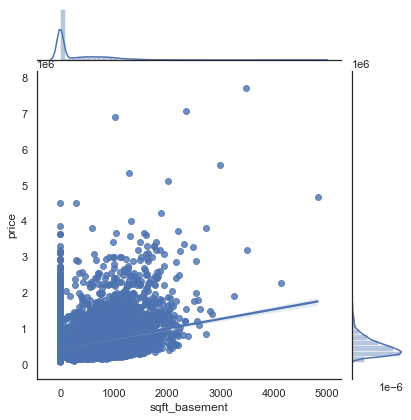

In [370]:
sns.jointplot('sqft_basement','price', data=df, kind='reg');

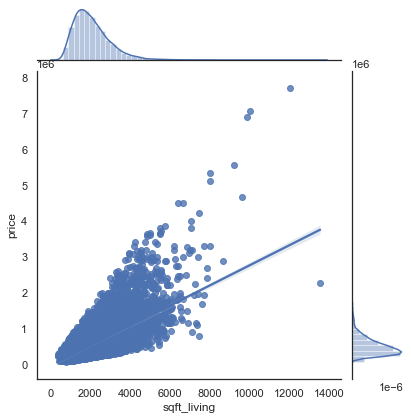

In [371]:
sns.jointplot('sqft_living','price', data=df, kind='reg');

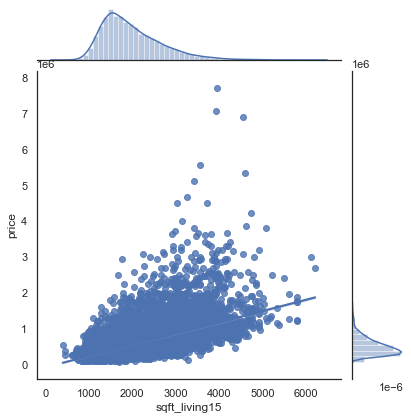

In [372]:
sns.jointplot('sqft_living15','price', data=df, kind='reg');

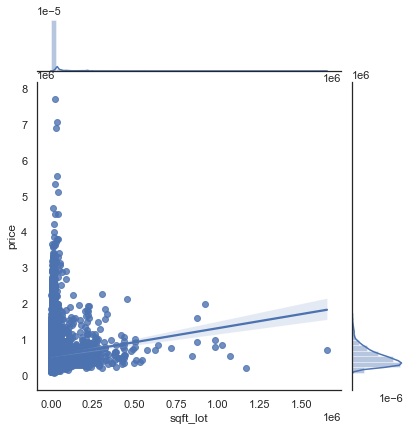

In [373]:
sns.jointplot('sqft_lot','price', data=df, kind='reg');

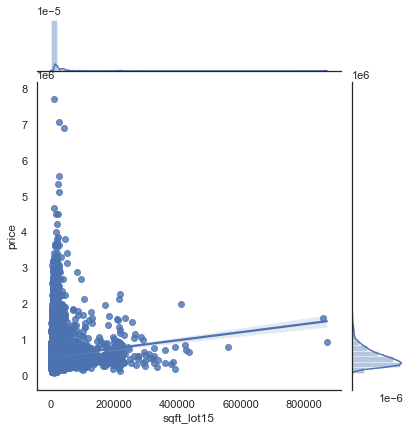

In [374]:
sns.jointplot('sqft_lot15','price', data=df, kind='reg');

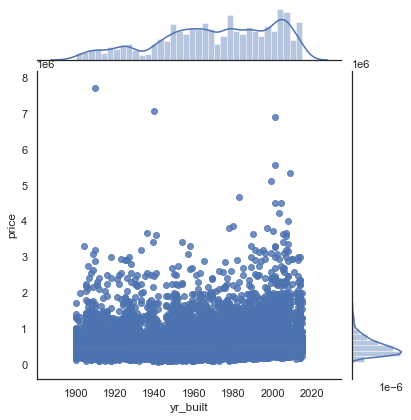

In [375]:
sns.jointplot('yr_built','price', data=df, kind='reg');

## Check for Multicollinearity

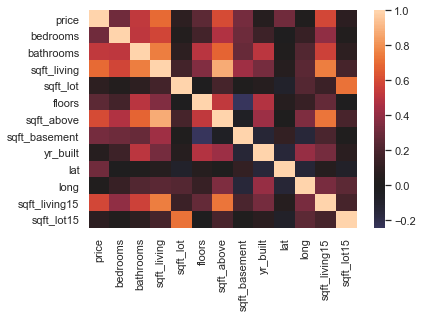

In [376]:
sns.heatmap(df.corr(), center=0);

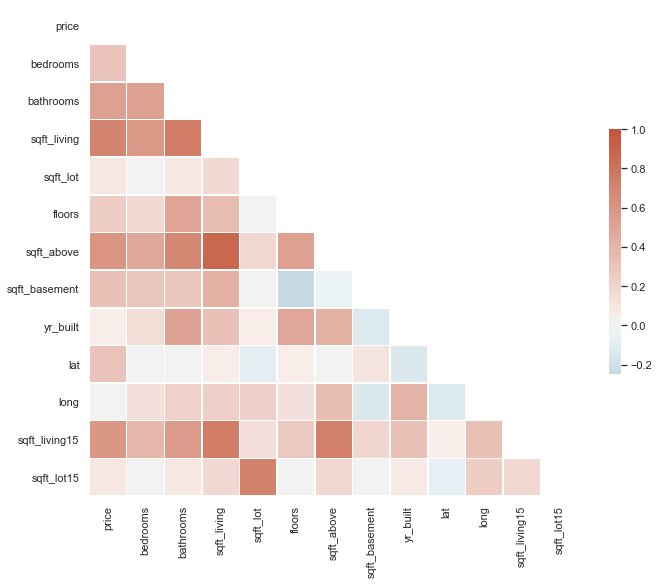

In [377]:
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [378]:
df.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15
price,1.000000,0.308454,0.525029,0.702004,0.088400,0.256603,0.605481,0.323018,0.054849,0.307667,0.022512,0.586495,0.083530
bedrooms,0.308454,1.000000,0.513694,0.577696,0.032531,0.178518,0.478967,0.301987,0.156820,-0.009939,0.131398,0.391936,0.030779
bathrooms,0.525029,0.513694,1.000000,0.754793,0.088451,0.503796,0.685959,0.281813,0.508866,0.025243,0.224660,0.569396,0.089414
sqft_living,0.702004,0.577696,0.754793,1.000000,0.173266,0.354260,0.876787,0.433369,0.319584,0.053213,0.241473,0.756199,0.184920
sqft_lot,0.088400,0.032531,0.088451,0.173266,1.000000,-0.007745,0.183653,0.015612,0.052469,-0.085076,0.230489,0.143815,0.719499
floors,0.256603,0.178518,0.503796,0.354260,-0.007745,1.000000,0.523594,-0.245628,0.489898,0.049237,0.125360,0.279379,-0.011632
sqft_above,0.605481,0.478967,0.685959,0.876787,0.183653,0.523594,1.000000,-0.053403,0.425170,-0.000014,0.344774,0.730794,0.195983
sqft_basement,0.323018,0.301987,0.281813,0.433369,0.015612,-0.245628,-0.053403,1.000000,-0.133178,0.110526,-0.144709,0.200709,0.016705
yr_built,0.054849,0.156820,0.508866,0.319584,0.052469,0.489898,0.425170,-0.133178,1.000000,-0.148165,0.409009,0.325657,0.071184
lat,0.307667,-0.009939,0.025243,0.053213,-0.085076,0.049237,-0.000014,0.110526,-0.148165,1.000000,-0.135173,0.050357,-0.084799


In [379]:
abs(df.corr()) > 0.75

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15
price,True,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,True,True,False,False,False,False,False,False,False,False,False
sqft_living,False,False,True,True,False,False,True,False,False,False,False,True,False
sqft_lot,False,False,False,False,True,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,True,False,False,False,False,False,False,False
sqft_above,False,False,False,True,False,False,True,False,False,False,False,False,False
sqft_basement,False,False,False,False,False,False,False,True,False,False,False,False,False
yr_built,False,False,False,False,False,False,False,False,True,False,False,False,False
lat,False,False,False,False,False,False,False,False,False,True,False,False,False


In [380]:
# save absolute value of correlation matrix as a data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df_abs = df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df_abs['pairs'] = list(zip(df_abs.level_0, df_abs.level_1))

# set index to pairs
df_abs.set_index(['pairs'], inplace = True)

#d rop level columns
df_abs.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df_abs.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
df_abs.drop_duplicates(inplace=True)

In [381]:
df_abs[(df_abs.cc>.75) & (df_abs.cc <1)]

,cc
pairs,
"(sqft_above, sqft_living)",0.876787
"(sqft_living, sqft_living15)",0.756199
"(sqft_living, bathrooms)",0.754793


In [382]:
# Drop sqft_living as it is highly correlated to sqft_above, sqft_living15, and bathrooms
df.drop('sqft_living', axis = 1, inplace = True)

In [383]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21082 entries, 0 to 21596
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21082 non-null  float64
 1   bedrooms       21082 non-null  int64  
 2   bathrooms      21082 non-null  float64
 3   sqft_lot       21082 non-null  int64  
 4   floors         21082 non-null  float64
 5   waterfront     21082 non-null  object 
 6   view           21082 non-null  object 
 7   condition      21082 non-null  object 
 8   grade          21082 non-null  object 
 9   sqft_above     21082 non-null  int64  
 10  sqft_basement  21082 non-null  float64
 11  yr_built       21082 non-null  int64  
 12  zipcode        21082 non-null  object 
 13  lat            21082 non-null  float64
 14  long           21082 non-null  float64
 15  sqft_living15  21082 non-null  int64  
 16  sqft_lot15     21082 non-null  int64  
dtypes: float64(6), int64(6), object(5)
memory usage: 2

## Normalize Data

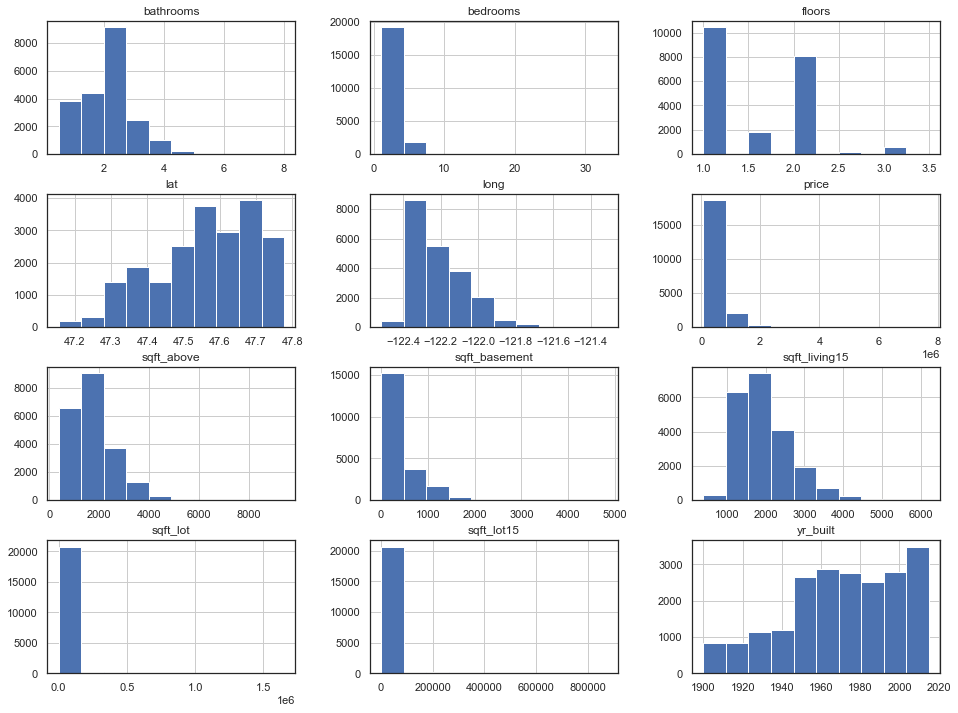

In [384]:
df.hist(figsize=(16,12));

In [385]:
# Log transform to reduce skewness
# Don't bother to normalize the price as this is the feature you will be predicting
cont_data = ['bathrooms', 'bedrooms', 'floors', 'lat', 'sqft_above', 'sqft_living15', 'sqft_lot', 'sqft_lot15', 'yr_built']
for var in cont_data:
    df[var]= np.log(df[var])
df.describe()

#(Also remember that you can't take the logarithm of zero nor a negative number.)
#will not work on log negatives and sqft_basement due to 0s

,price,bedrooms,bathrooms,sqft_lot,floors,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15
count,2.108200e+04,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000
mean,5.402469e+05,1.177712,0.677803,8.990663,0.338189,7.395389,291.359975,7.586197,3.861996,-122.213843,7.539641,8.961429
std,3.667323e+05,0.282684,0.392118,0.901414,0.352171,0.427009,442.007858,0.014932,0.002916,0.140607,0.327421,0.811068
min,7.800000e+04,0.000000,-0.693147,6.253829,0.000000,5.913503,0.000000,7.549609,3.853459,-122.519000,5.988961,6.478510
25%,3.220000e+05,1.098612,0.559616,8.525161,0.000000,7.090077,0.000000,7.576610,3.860126,-122.328000,7.306531,8.536996
50%,4.500000e+05,1.098612,0.810930,8.938532,0.405465,7.352441,0.000000,7.588324,3.862249,-122.230000,7.517521,8.939319
75%,6.450000e+05,1.386294,0.916291,9.277789,0.693147,7.700748,560.000000,7.599401,3.864474,-122.125000,7.766417,9.219176
max,7.700000e+06,3.496508,2.079442,14.317109,1.252763,9.149528,4820.000000,7.608374,3.866557,-121.315000,8.733916,13.677627


In [386]:
# Standardization (z-score normalization)
# x' will have mean  𝜇=0  and  𝜎=1 
# Note that standardization does not make data  𝑚𝑜𝑟𝑒  normal, it will just change the mean and the standard error!
for item in cont_data:
    df[item] = (df[item] - df[item].mean()) / df[item].std()

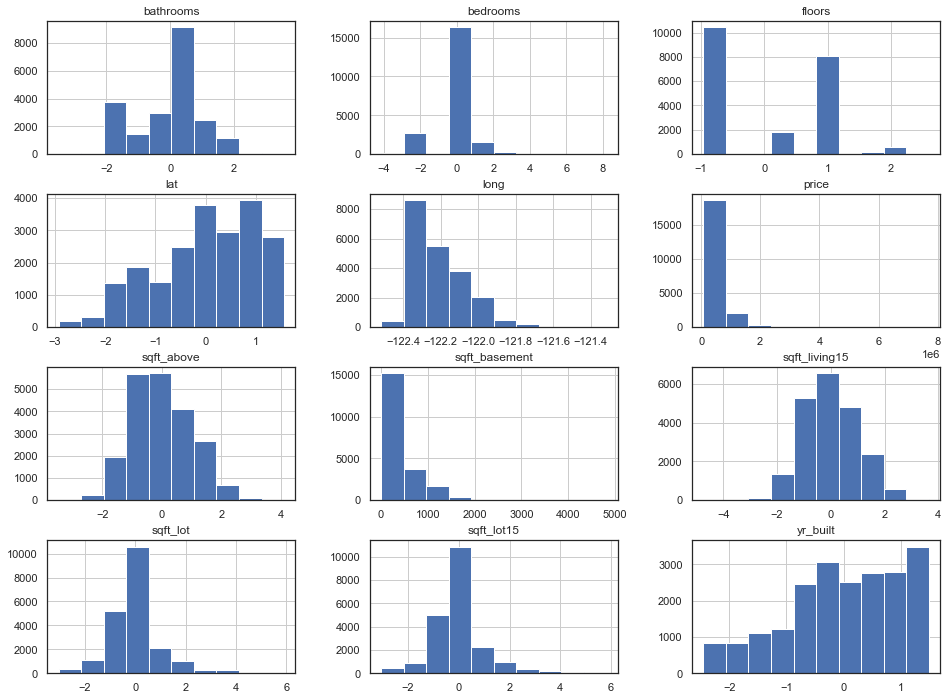

In [387]:
df.hist(figsize=(16,12));

In [388]:
# One-hot encode categorical data
df = pd.get_dummies(df) 
df.head()

,price,bedrooms,bathrooms,sqft_lot,floors,sqft_above,sqft_basement,yr_built,lat,long,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,221900.0,-0.279815,-1.728568,-0.389668,-0.960295,-0.754362,0.0,-0.539199,-0.353321,-122.257,...,0,0,0,0,0,0,1,0,0,0
1,538000.0,-0.279815,0.339508,-0.114277,1.007914,0.672337,400.0,-0.676360,1.157882,-122.319,...,0,0,0,0,0,0,0,0,0,0
2,180000.0,-1.714154,-1.728568,0.243703,-0.960295,-1.754058,0.0,-1.297086,1.279324,-122.233,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,0.737865,1.073170,-0.525253,-0.960295,-1.027715,910.0,-0.197520,-0.284026,-122.393,...,0,0,0,0,0,0,0,0,0,0
4,510000.0,-0.279815,0.039132,0.007193,-0.960295,0.072974,0.0,0.548094,0.408155,-122.045,...,0,0,0,0,0,0,0,0,0,0


In [389]:
for col in df.columns: 
    print(col) 

price
bedrooms
bathrooms
sqft_lot
floors
sqft_above
sqft_basement
yr_built
lat
long
sqft_living15
sqft_lot15
waterfront_0.0
waterfront_1.0
view_0.0
view_1.0
view_2.0
view_3.0
view_4.0
condition_1
condition_2
condition_3
condition_4
condition_5
grade_10
grade_11
grade_12
grade_13
grade_3
grade_4
grade_5
grade_6
grade_7
grade_8
grade_9
zipcode_98001
zipcode_98002
zipcode_98003
zipcode_98004
zipcode_98005
zipcode_98006
zipcode_98007
zipcode_98008
zipcode_98010
zipcode_98011
zipcode_98014
zipcode_98019
zipcode_98022
zipcode_98023
zipcode_98024
zipcode_98027
zipcode_98028
zipcode_98029
zipcode_98030
zipcode_98031
zipcode_98032
zipcode_98033
zipcode_98034
zipcode_98038
zipcode_98039
zipcode_98040
zipcode_98042
zipcode_98045
zipcode_98052
zipcode_98053
zipcode_98055
zipcode_98056
zipcode_98058
zipcode_98059
zipcode_98065
zipcode_98070
zipcode_98072
zipcode_98074
zipcode_98075
zipcode_98077
zipcode_98092
zipcode_98102
zipcode_98103
zipcode_98105
zipcode_98106
zipcode_98107
zipcode_98108
zipcod

In [390]:
df.describe()

,price,bedrooms,bathrooms,sqft_lot,floors,sqft_above,sqft_basement,yr_built,lat,long,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
count,2.108200e+04,2.108200e+04,2.108200e+04,2.108200e+04,2.108200e+04,2.108200e+04,21082.000000,2.108200e+04,2.108200e+04,21082.000000,...,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000
mean,5.402469e+05,2.485392e-13,-2.282493e-13,-4.924482e-14,-1.180081e-13,2.384871e-13,291.359975,3.345576e-11,-3.366850e-12,-122.213843,...,0.013187,0.002609,0.020634,0.011764,0.012380,0.011906,0.012238,0.006214,0.012807,0.014847
std,3.667323e+05,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,442.007858,1.000000e+00,1.000000e+00,0.140607,...,0.114076,0.051012,0.142158,0.107823,0.110578,0.108465,0.109949,0.078584,0.112444,0.120942
min,7.800000e+04,-4.166173e+00,-3.496268e+00,-3.036158e+00,-9.602954e-01,-3.470388e+00,0.000000,-2.450246e+00,-2.927854e+00,-122.519000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.220000e+05,-2.798151e-01,-3.014067e-01,-5.164131e-01,-9.602954e-01,-7.150016e-01,0.000000,-6.420433e-01,-6.412973e-01,-122.328000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.500000e+05,-2.798151e-01,3.395084e-01,-5.783302e-02,1.910334e-01,-1.005779e-01,0.000000,1.424252e-01,8.675308e-02,-122.230000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.450000e+05,7.378647e-01,6.082042e-01,3.185282e-01,1.007914e+00,7.151120e-01,560.000000,8.842844e-01,8.501308e-01,-122.125000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.700000e+06,8.202777e+00,3.574532e+00,5.908993e+00,2.596958e+00,4.107971e+00,4820.000000,1.485206e+00,1.564437e+00,-121.315000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 4. Explore Data

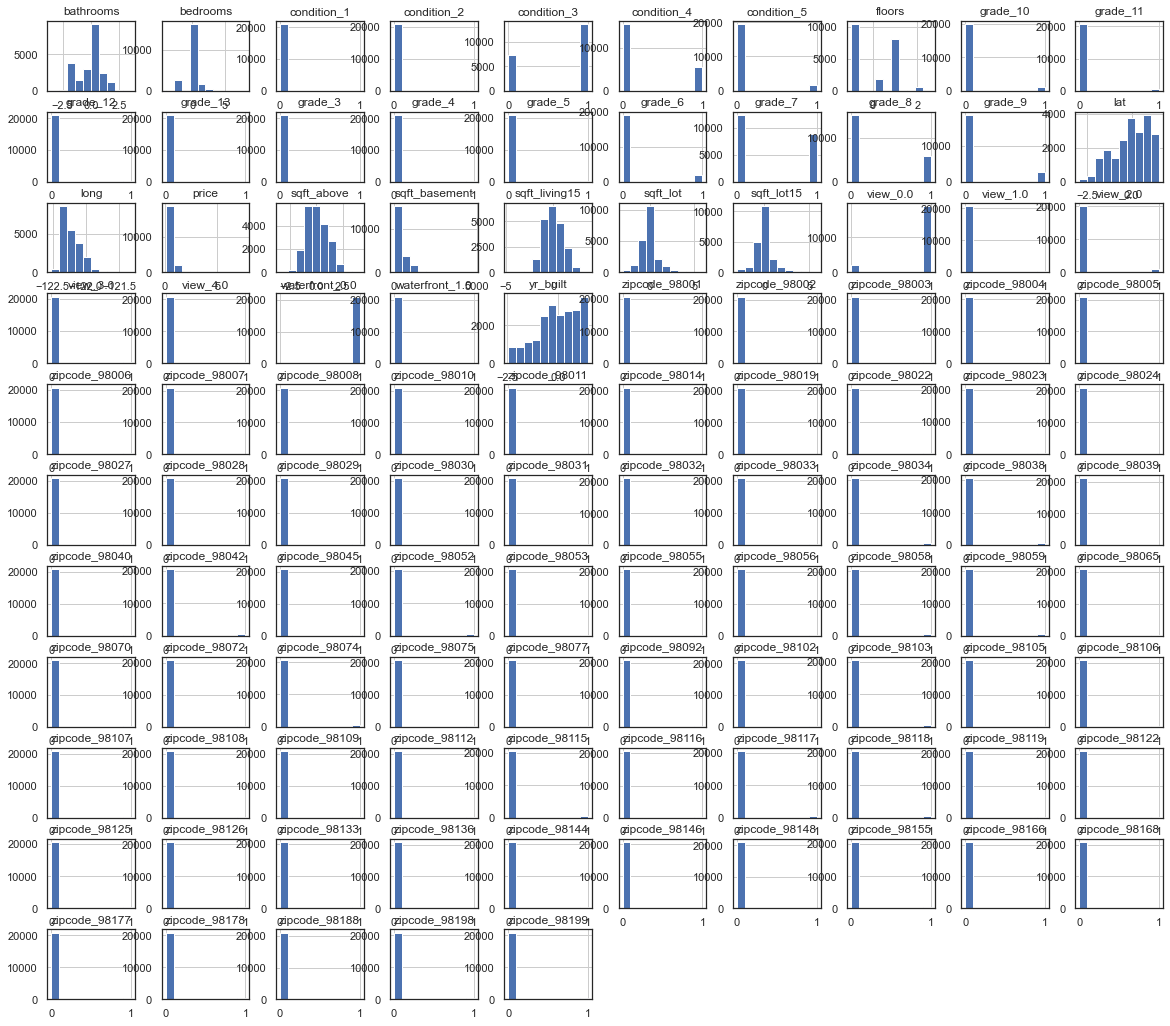

In [391]:
df.hist(figsize = (20,18));

## 5. Model

In [392]:
subs = [(' ', '_'),('.',''),("'",""),('™', ''), ('®',''),
        ('+','plus'), ('½','half'), ('-','_')
       ]
def col_formatting(col):
    for old, new in subs:
        col = col.replace(old,new)
    return col

In [393]:
df.columns = [col_formatting(col) for col in df.columns]

In [394]:
list(df.columns)

['price',
 'bedrooms',
 'bathrooms',
 'sqft_lot',
 'floors',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'waterfront_00',
 'waterfront_10',
 'view_00',
 'view_10',
 'view_20',
 'view_30',
 'view_40',
 'condition_1',
 'condition_2',
 'condition_3',
 'condition_4',
 'condition_5',
 'grade_10',
 'grade_11',
 'grade_12',
 'grade_13',
 'grade_3',
 'grade_4',
 'grade_5',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'zipcode_98001',
 'zipcode_98002',
 'zipcode_98003',
 'zipcode_98004',
 'zipcode_98005',
 'zipcode_98006',
 'zipcode_98007',
 'zipcode_98008',
 'zipcode_98010',
 'zipcode_98011',
 'zipcode_98014',
 'zipcode_98019',
 'zipcode_98022',
 'zipcode_98023',
 'zipcode_98024',
 'zipcode_98027',
 'zipcode_98028',
 'zipcode_98029',
 'zipcode_98030',
 'zipcode_98031',
 'zipcode_98032',
 'zipcode_98033',
 'zipcode_98034',
 'zipcode_98038',
 'zipcode_98039',
 'zipcode_98040',
 'zipcode_98042',
 'zipcode_98045',
 'zipcode_98052',
 'zipcode

In [395]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21082 entries, 0 to 21596
Columns: 105 entries, price to zipcode_98199
dtypes: float64(12), uint8(93)
memory usage: 4.0 MB


In [396]:
# Defining the problem
outcome = 'price'
x_cols = list(df.columns)
x_cols.remove(outcome)

In [397]:
train, test = train_test_split(df)

In [398]:
print(len(train), len(test))
train.head()

15811 5271


,price,bedrooms,bathrooms,sqft_lot,floors,sqft_above,sqft_basement,yr_built,lat,long,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
7821,597000.0,0.737865,0.039132,-0.772801,0.191033,0.128079,400.0,-1.505280,0.920622,-122.383,...,0,0,0,0,0,0,0,0,0,0
1278,445000.0,-0.279815,0.608204,-0.626227,1.007914,0.975588,0.0,1.152027,-0.333108,-122.189,...,0,0,0,0,0,0,0,0,0,0
17914,428000.0,-0.279815,0.608204,-0.931766,1.007914,0.848970,0.0,1.118617,-0.201756,-121.851,...,0,0,0,0,0,0,0,0,0,0
18223,591000.0,-0.279815,0.039132,-0.889685,1.007914,-0.255726,0.0,-2.379789,0.375740,-122.314,...,0,0,0,0,0,0,0,0,0,0
14746,285000.0,-0.279815,0.339508,-0.284113,-0.960295,-0.582228,570.0,0.413144,-1.125896,-122.185,...,0,0,0,0,0,0,0,0,0,0


In [399]:
test.head()

,price,bedrooms,bathrooms,sqft_lot,floors,sqft_above,sqft_basement,yr_built,lat,long,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
198,440000.0,-0.279815,0.608204,2.340700,1.007914,0.373458,0.0,0.884284,-0.156300,-121.911,...,0,0,0,0,0,0,0,0,0,0
18454,220000.0,-1.714154,-1.728568,-0.569615,-0.960295,-1.414883,0.0,-1.470536,1.026330,-122.346,...,0,0,0,0,0,0,0,0,0,0
2900,305000.0,0.737865,0.339508,0.198416,-0.960295,0.628766,0.0,-0.163447,-1.070913,-122.211,...,0,0,0,0,0,0,0,0,0,0
16677,429000.0,-0.279815,0.608204,0.702646,1.007914,0.385687,0.0,0.817181,-0.423352,-121.773,...,0,0,0,0,0,0,0,0,0,0
1161,482500.0,2.172204,2.107208,-0.075442,0.191033,1.383522,0.0,-0.163447,1.156444,-122.182,...,0,0,0,0,0,0,0,0,0,0


In [400]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     764.9
Date:                Wed, 10 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:08:04   Log-Likelihood:            -2.1112e+05
No. Observations:               15811   AIC:                         4.224e+05
Df Residuals:                   15711   BIC:                         4.232e+05
Df Model:                          99                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.232e+07   3.14e+06     -3.928      0.000   -1.85e+07   -6.17e+06
bedrooms      -1.194e+04   1687.650     -7.077      0.000   -1.53e+04   -8635.348
bathrooms      1.107e+04   2231.497      4.960      0.000    6693.846    1.54e+04
sqft_lot       3.127e+04   3248.890      9.626      0.000    2.49e+04    3.76e+04
floors        -5525.1027   2034.233     -2.716      0.007   -9512.433   -1537.772
sqft_above     1.165e+05   2952.955     39.454      0.000    1.11e+05    1.22e+05
sqft_basement   113.2178      3.942     28.718      0.000     105.490     120.945
yr_built      -8681.3144   2096.019     -4.142      0.000   -1.28e+04   -4572.875
lat            2.962e+04   9842.400      3.009      0.003    1.03e+04    4.89e+04
long          -2.128e+05   5.15e+04     -4.133      0.000   -3.14e+05   -1.12e+05
sqft_living15  9692.9978   2165.189      4.477      0.000    5448.978    1.39e+04
sqft_lot15    -1.222e+04   3232.124     -3.782      0.000   -1.86e+04   -5887.557
waterfront_00 -6.468e+06   1.57e+06     -4.123      0.000   -9.54e+06   -3.39e+06
waterfront_10 -5.856e+06   1.57e+06     -3.732      0.000   -8.93e+06   -2.78e+06
view_00        -2.59e+06   6.27e+05     -4.128      0.000   -3.82e+06   -1.36e+06
view_10       -2.497e+06   6.28e+05     -3.978      0.000   -3.73e+06   -1.27e+06
view_20       -2.517e+06   6.28e+05     -4.011      0.000   -3.75e+06   -1.29e+06
view_30       -2.435e+06   6.28e+05     -3.880      0.000   -3.66e+06    -1.2e+06
view_40       -2.285e+06   6.28e+05     -3.640      0.000   -3.52e+06   -1.05e+06
condition_1   -2.587e+06   6.28e+05     -4.120      0.000   -3.82e+06   -1.36e+06
condition_2    -2.47e+06   6.28e+05     -3.934      0.000    -3.7e+06   -1.24e+06
condition_3   -2.452e+06   6.28e+05     -3.907      0.000   -3.68e+06   -1.22e+06
condition_4   -2.433e+06   6.28e+05     -3.876      0.000   -3.66e+06    -1.2e+06
condition_5   -2.383e+06   6.28e+05     -3.797      0.000   -3.61e+06   -1.15e+06
grade_10      -1.284e+06   2.86e+05     -4.493      0.000   -1.84e+06   -7.24e+05
grade_11       -9.97e+05   2.86e+05     -3.487      0.000   -1.56e+06   -4.36e+05
grade_12      -5.271e+05   2.86e+05     -1.843      0.065   -1.09e+06    3.34e+04
grade_13       8.098e+05    2.9e+05      2.793      0.005    2.41e+05    1.38e+06
grade_3       -1.312e+06   3.18e+05     -4.131      0.000   -1.94e+06    -6.9e+05
grade_4       -1.425e+06   2.87e+05     -4.958      0.000   -1.99e+06   -8.62e+05
grade_5       -1.522e+06   2.85e+05     -5.331      0.000   -2.08e+06   -9.62e+05
grade_6       -1.542e+06   2.86e+05     -5.400      0.000    -2.1e+06   -9.82e+05
grade_7       -1.554e+06   2.86e+05     -5.441      0.000   -2.11e+06   -9.94e+05
grade_8       -1.534e+06   2.86e+05     -5.369      0.000   -2.09e+06   -9.74e+05
grade_9       -1.436e+06   2.86e+05     -5.027   

## Remove the Uninfluential Features

In [401]:
# Extract the p-value table from the summary and use it to subset our features (p < 0.05)
summary = model.summary()
p_table = summary.tables[1]
p_table = pd.DataFrame(p_table.data)
p_table.columns = p_table.iloc[0]
p_table = p_table.drop(0)
p_table = p_table.set_index(p_table.columns[0])
p_table['P>|t|'] = p_table['P>|t|'].astype(float)
x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
x_cols.remove('Intercept')
print(len(p_table), len(x_cols))
print(x_cols[:5])
p_table.head()

105 90
['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'sqft_above']


,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
Intercept,-1.232e+07,3.14e+06,-3.928,0.000,-1.85e+07,-6.17e+06
bedrooms,-1.194e+04,1687.650,-7.077,0.000,-1.53e+04,-8635.348
bathrooms,1.107e+04,2231.497,4.960,0.000,6693.846,1.54e+04
sqft_lot,3.127e+04,3248.890,9.626,0.000,2.49e+04,3.76e+04
floors,-5525.1027,2034.233,-2.716,0.007,-9512.433,-1537.772


In [402]:
# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     843.2
Date:                Wed, 10 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:08:05   Log-Likelihood:            -2.1134e+05
No. Observations:               15811   AIC:                         4.228e+05
Df Residuals:                   15723   BIC:                         4.235e+05
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.157e+07   2.25e+06     -5.133      0.000    -1.6e+07   -7.15e+06
bedrooms      -1.155e+04   1707.436     -6.767      0.000   -1.49e+04   -8207.672
bathrooms      1.215e+04   2257.668      5.381      0.000    7723.107    1.66e+04
sqft_lot       2.933e+04   3287.492      8.920      0.000    2.29e+04    3.58e+04
floors        -4193.3755   2029.774     -2.066      0.039   -8171.966    -214.785
sqft_above     1.144e+05   2982.355     38.359      0.000    1.09e+05     1.2e+05
sqft_basement   112.5686      3.984     28.256      0.000     104.760     120.378
yr_built      -1.428e+04   2055.832     -6.945      0.000   -1.83e+04   -1.02e+04
lat            4.892e+04   7237.359      6.759      0.000    3.47e+04    6.31e+04
long          -1.964e+05    3.5e+04     -5.606      0.000   -2.65e+05   -1.28e+05
sqft_living15  1.198e+04   2178.352      5.499      0.000    7708.082    1.62e+04
sqft_lot15    -1.317e+04   3266.924     -4.031      0.000   -1.96e+04   -6764.215
waterfront_00 -6.095e+06   1.13e+06     -5.406      0.000    -8.3e+06   -3.88e+06
waterfront_10 -5.478e+06   1.13e+06     -4.860      0.000   -7.69e+06   -3.27e+06
view_00       -2.439e+06   4.51e+05     -5.412      0.000   -3.32e+06   -1.56e+06
view_10       -2.344e+06   4.51e+05     -5.199      0.000   -3.23e+06   -1.46e+06
view_20       -2.366e+06   4.51e+05     -5.247      0.000   -3.25e+06   -1.48e+06
view_30       -2.282e+06   4.51e+05     -5.060      0.000   -3.17e+06    -1.4e+06
view_40       -2.141e+06   4.51e+05     -4.744      0.000   -3.03e+06   -1.26e+06
condition_1   -2.443e+06   4.52e+05     -5.405      0.000   -3.33e+06   -1.56e+06
condition_2   -2.319e+06   4.51e+05     -5.140      0.000    -3.2e+06   -1.43e+06
condition_3   -2.299e+06   4.51e+05     -5.097      0.000   -3.18e+06   -1.41e+06
condition_4   -2.281e+06   4.51e+05     -5.058      0.000   -3.16e+06    -1.4e+06
condition_5   -2.232e+06   4.51e+05     -4.950      0.000   -3.12e+06   -1.35e+06
grade_10       -7.58e+05   2.07e+04    -36.693      0.000   -7.99e+05   -7.18e+05
grade_11      -4.697e+05   2.18e+04    -21.584      0.000   -5.12e+05   -4.27e+05
grade_13       1.369e+06   5.55e+04     24.672      0.000    1.26e+06    1.48e+06
grade_3       -8.044e+05   1.57e+05     -5.118      0.000   -1.11e+06   -4.96e+05
grade_4       -9.112e+05   4.16e+04    -21.901      0.000   -9.93e+05    -8.3e+05
grade_5       -1.011e+06   2.53e+04    -39.994      0.000   -1.06e+06   -9.61e+05
grade_6       -1.029e+06   2.22e+04    -46.362      0.000   -1.07e+06   -9.85e+05
grade_7       -1.038e+06   2.12e+04    -48.872      0.000   -1.08e+06   -9.96e+05
grade_8       -1.014e+06   2.07e+04    -48.923      0.000   -1.05e+06   -9.74e+05
grade_9       -9.114e+05   2.05e+04    -44.477      0.000   -9.52e+05   -8.71e+05
zipcode_98001  -2.44e+05   2.06e+04    -11.817   

Comment: You should see that the model performance is identical. Additionally, observe that there are further features which have been identified as unimpactful. Continue to refine the model accordingly.

## 6. Investigate Multicollinearity

There are still a lot of features in the current model! Chances are there are some strong multicollinearity issues. Begin to investigate the extent of this problem.

In [405]:
# A VIF between 5 and 10 indicates high correlation that may be problematic. And if the VIF goes above 10, you can assume that the regression coefficients are poorly estimated due to multicollinearity.
# Inf = This shows a perfect correlation between two independent variables. In the case of perfect correlation, we get R2 =1, which lead to 1/(1-R2) infinity. To solve this problem we need to drop one of the variables from the dataset which is causing this perfect multicollinearity.
# need to drop one column for each categorical data is dropped to avoid a singularity occurring 
X = df[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('bedrooms', 1.920232509012926),
 ('bathrooms', 3.330341579760898),
 ('sqft_lot', 7.116470827310401),
 ('floors', 2.7114389458129837),
 ('sqft_above', 5.825020544133036),
 ('sqft_basement', 2.0113381498897875),
 ('yr_built', 2.761978972427813),
 ('lat', 34.416470641169674),
 ('long', 15.902762013934083),
 ('sqft_living15', 3.0893074630224877),
 ('sqft_lot15', 6.98413440505578),
 ('waterfront_00', inf),
 ('waterfront_10', inf),
 ('view_00', inf),
 ('view_10', inf),
 ('view_20', inf),
 ('view_30', inf),
 ('view_40', inf),
 ('condition_1', inf),
 ('condition_2', inf),
 ('condition_3', inf),
 ('condition_4', inf),
 ('condition_5', inf),
 ('grade_10', 13.393716237924126),
 ('grade_11', 5.418141530015903),
 ('grade_13', 1.1585208603457589),
 ('grade_3', 1.022129716355392),
 ('grade_4', 1.4355702636082648),
 ('grade_5', 4.500868489878917),
 ('grade_6', 26.845072882615845),
 ('grade_7', 69.56943379267656),
 ('grade_8', 54.95621134639983),
 ('grade_9', 28.158520156884055),
 ('zipcode_98001', 4

## Perform Another Round of Feature Selection

In [406]:
# Once again, subset your features based on your findings above. Then rerun the model once again.
vif_scores = list(zip(x_cols, vif))
x_cols = [x for x,vif in vif_scores if vif < 5]
print(len(vif_scores), len(x_cols))

90 63


In [407]:
# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     374.4
Date:                Wed, 10 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:08:13   Log-Likelihood:            -2.1781e+05
No. Observations:               15811   AIC:                         4.358e+05
Df Residuals:                   15747   BIC:                         4.362e+05
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.193e+05   4088.315    127.018      0.000    5.11e+05    5.27e+05
bedrooms      -1.069e+04   2324.566     -4.600      0.000   -1.52e+04   -6135.457
bathrooms      6.693e+04   3160.282     21.179      0.000    6.07e+04    7.31e+04
floors         6.842e+04   2595.215     26.364      0.000    6.33e+04    7.35e+04
sqft_basement   145.0529      5.340     27.164      0.000     134.586     155.520
yr_built      -7.445e+04   2550.041    -29.195      0.000   -7.94e+04   -6.94e+04
sqft_living15  1.196e+05   2596.709     46.042      0.000    1.14e+05    1.25e+05
grade_13       2.355e+06   7.83e+04     30.079      0.000     2.2e+06    2.51e+06
grade_3       -7.767e+04   2.33e+05     -0.333      0.739   -5.35e+05     3.8e+05
grade_4       -3.085e+04   5.27e+04     -0.585      0.558   -1.34e+05    7.24e+04
grade_5       -3759.5289   1.85e+04     -0.203      0.839      -4e+04    3.25e+04
zipcode_98001 -2.058e+05   1.49e+04    -13.815      0.000   -2.35e+05   -1.77e+05
zipcode_98002 -1.753e+05   1.96e+04     -8.965      0.000   -2.14e+05   -1.37e+05
zipcode_98003 -2.089e+05   1.65e+04    -12.621      0.000   -2.41e+05   -1.76e+05
zipcode_98004  6.639e+05   1.57e+04     42.198      0.000    6.33e+05    6.95e+05
zipcode_98006  9.913e+04   1.32e+04      7.505      0.000    7.32e+04    1.25e+05
zipcode_98007  2.459e+04   2.29e+04      1.075      0.282   -2.03e+04    6.94e+04
zipcode_98008  6.203e+04   1.66e+04      3.746      0.000    2.96e+04    9.45e+04
zipcode_98010 -8.854e+04   2.74e+04     -3.230      0.001   -1.42e+05   -3.48e+04
zipcode_98011 -1.187e+05   2.09e+04     -5.694      0.000    -1.6e+05   -7.79e+04
zipcode_98014 -4.319e+04   2.44e+04     -1.769      0.077    -9.1e+04    4661.149
zipcode_98019  -1.37e+05   1.99e+04     -6.876      0.000   -1.76e+05    -9.8e+04
zipcode_98024  1.188e+04    3.5e+04      0.340      0.734   -5.66e+04    8.04e+04
zipcode_98027 -4.779e+04   1.43e+04     -3.353      0.001   -7.57e+04   -1.98e+04
zipcode_98028 -1.184e+05   1.65e+04     -7.163      0.000   -1.51e+05    -8.6e+04
zipcode_98029 -1093.8810    1.6e+04     -0.068      0.946   -3.25e+04    3.03e+04
zipcode_98030 -2.214e+05   1.73e+04    -12.814      0.000   -2.55e+05   -1.88e+05
zipcode_98031 -2.207e+05   1.67e+04    -13.210      0.000   -2.53e+05   -1.88e+05
zipcode_98032 -2.018e+05   2.52e+04     -8.012      0.000   -2.51e+05   -1.52e+05
zipcode_98034 -1.059e+04   1.25e+04     -0.849      0.396    -3.5e+04    1.39e+04
zipcode_98039   1.21e+06   3.87e+04     31.236      0.000    1.13e+06    1.29e+06
zipcode_98040   3.92e+05   1.69e+04     23.186      0.000    3.59e+05    4.25e+05
zipcode_98045 -6.007e+04   1.91e+04     -3.151      0.002   -9.74e+04   -2.27e+04
zipcode_98052  2.613e+04   1.23e+04      2.120      0.034    1974.947    5.03e+04
zipcode_98053   7.91e+04   1.43e+04      5.530   

## Check the Normality Assumption

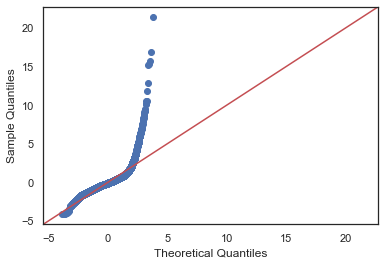

In [408]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

## Check Homoscedasticity Assumption

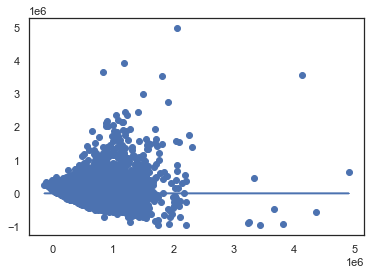

In [409]:
# Check whether the model's errors are indeed homoscedastic or if they violate this principle and display heteroscedasticity.
plt.scatter(model.predict(train[x_cols]), model.resid)
plt.plot(model.predict(train[x_cols]), [0 for i in range(len(train))])

Comment: This displays a fairly pronounced 'funnel' shape: errors appear to increase as the list_price increases. This doesn't bode well for our model. Subsetting the data to remove outliers and confining the model to this restricted domain may be necessary. A log transformation or something equivalent may also be appropriate.

## Make Additional Refinements

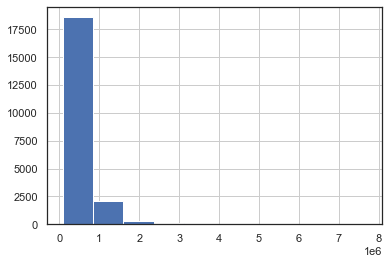

In [410]:
# From here, make additional refinements to your model based on the above analysis. As you progress, continue to go back and check the assumptions for the updated model. Be sure to attempt at least two additional model refinements.
#Comment: Based on the above plots, it seems as though outliers are having a substantial impact on the model. As such, removing outliers may be appropriate. Investigating the impact of a log transformation is also worthwhile.
df.price.hist();

In [411]:
for i in range(80,100):
    q = i/100
    print("{} percentile: {}".format(q, df.price.quantile(q=q)))

0.8 percentile: 702000.0
0.81 percentile: 719000.0
0.82 percentile: 732000.0
0.83 percentile: 750000.0
0.84 percentile: 762000.0
0.85 percentile: 780000.0
0.86 percentile: 799000.0
0.87 percentile: 815000.0
0.88 percentile: 838327.9999999999
0.89 percentile: 860000.0
0.9 percentile: 888999.0
0.91 percentile: 920000.0
0.92 percentile: 950000.0
0.93 percentile: 997966.5000000001
0.94 percentile: 1070000.0
0.95 percentile: 1160000.0
0.96 percentile: 1260000.0
0.97 percentile: 1390000.0
0.98 percentile: 1600000.0
0.99 percentile: 1970000.0


In [412]:
orig_tot = len(df)
df = df[df.price < 1300000] # Subsetting to remove extreme outliers
print('Percent removed:', (orig_tot -len(df))/orig_tot)
df.list_price = df.price.map(np.log) # Applying a log transformation
train, test = train_test_split(df)

# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

Percent removed: 0.037377857888245894


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     396.0
Date:                Wed, 10 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:08:14   Log-Likelihood:            -2.0186e+05
No. Observations:               15220   AIC:                         4.039e+05
Df Residuals:                   15157   BIC:                         4.043e+05
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4.997e+05   2504.589    199.526      0.000    4.95e+05    5.05e+05
bedrooms       1768.6792   1419.680      1.246      0.213   -1014.064    4551.423
bathrooms        4.1e+04   1941.493     21.117      0.000    3.72e+04    4.48e+04
floors         4.841e+04   1592.528     30.401      0.000    4.53e+04    5.15e+04
sqft_basement    80.8513      3.442     23.492      0.000      74.105      87.597
yr_built      -5.713e+04   1578.562    -36.189      0.000   -6.02e+04    -5.4e+04
sqft_living15  8.458e+04   1602.914     52.767      0.000    8.14e+04    8.77e+04
grade_13      -5.541e-08   6.54e-08     -0.847      0.397   -1.84e-07    7.28e-08
grade_3       -9.521e+04    1.4e+05     -0.682      0.495   -3.69e+05    1.79e+05
grade_4       -6.325e+04   3.42e+04     -1.852      0.064    -1.3e+05    3703.580
grade_5       -6.021e+04   1.08e+04     -5.573      0.000   -8.14e+04    -3.9e+04
zipcode_98001 -1.932e+05   8795.287    -21.964      0.000    -2.1e+05   -1.76e+05
zipcode_98002  -1.77e+05    1.2e+04    -14.801      0.000      -2e+05   -1.54e+05
zipcode_98003 -1.839e+05   1.01e+04    -18.247      0.000   -2.04e+05   -1.64e+05
zipcode_98004  3.144e+05   1.25e+04     25.185      0.000     2.9e+05    3.39e+05
zipcode_98006  1.302e+05   8170.587     15.929      0.000    1.14e+05    1.46e+05
zipcode_98007  6.388e+04   1.37e+04      4.655      0.000     3.7e+04    9.08e+04
zipcode_98008  5.401e+04   9995.011      5.404      0.000    3.44e+04    7.36e+04
zipcode_98010 -6.543e+04   1.63e+04     -4.013      0.000   -9.74e+04   -3.35e+04
zipcode_98011 -7.316e+04    1.2e+04     -6.083      0.000   -9.67e+04   -4.96e+04
zipcode_98014 -4.913e+04   1.49e+04     -3.307      0.001   -7.83e+04      -2e+04
zipcode_98019 -9.895e+04   1.19e+04     -8.286      0.000   -1.22e+05   -7.55e+04
zipcode_98024  3457.2893   1.86e+04      0.185      0.853   -3.31e+04       4e+04
zipcode_98027  -112.1062   8812.461     -0.013      0.990   -1.74e+04    1.72e+04
zipcode_98028 -7.265e+04   1.03e+04     -7.026      0.000   -9.29e+04   -5.24e+04
zipcode_98029  3.619e+04   9765.025      3.706      0.000    1.71e+04    5.53e+04
zipcode_98030 -1.964e+05   1.07e+04    -18.406      0.000   -2.17e+05   -1.76e+05
zipcode_98031 -1.909e+05   1.02e+04    -18.755      0.000   -2.11e+05   -1.71e+05
zipcode_98032 -1.946e+05   1.49e+04    -13.036      0.000   -2.24e+05   -1.65e+05
zipcode_98034 -1.287e+04   7466.441     -1.723      0.085   -2.75e+04    1766.813
zipcode_98039   3.93e+05   5.28e+04      7.438      0.000    2.89e+05    4.97e+05
zipcode_98040  2.583e+05   1.22e+04     21.190      0.000    2.34e+05    2.82e+05
zipcode_98045 -4.219e+04   1.11e+04     -3.807      0.000   -6.39e+04   -2.05e+04
zipcode_98052  8.076e+04   7361.282     10.971      0.000    6.63e+04    9.52e+04
zipcode_98053  1.193e+05   8699.328     13.716   

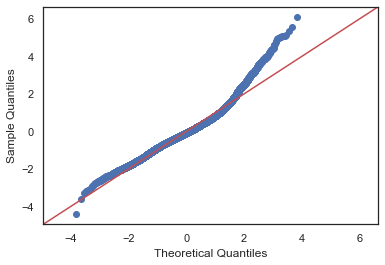

In [413]:
# Comment: This is much, much better!
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

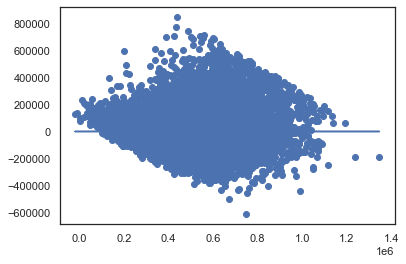

In [414]:
# Comment: There is still a clear underestimate now by the model as the log transformed 
# list price increases, but the model is much improved. Further subsetting is potentially warranted.
plt.scatter(model.predict(train[x_cols]), model.resid)
plt.plot(model.predict(train[x_cols]), [0 for i in range(len(train))])

0.8 percentile: 665000.0
0.81 percentile: 677000.0
0.82 percentile: 690000.0
0.83 percentile: 700000.0
0.84 percentile: 716000.0
0.85 percentile: 730000.0
0.86 percentile: 745992.8199999998
0.87 percentile: 760000.0
0.88 percentile: 775000.0
0.89 percentile: 790000.0
0.9 percentile: 809665.0000000007
0.91 percentile: 829000.0
0.92 percentile: 850000.0
0.93 percentile: 875000.0
0.94 percentile: 900000.0
0.95 percentile: 932802.8
0.96 percentile: 970000.0
0.97 percentile: 1020000.0
0.98 percentile: 1100000.0
0.99 percentile: 1200000.0


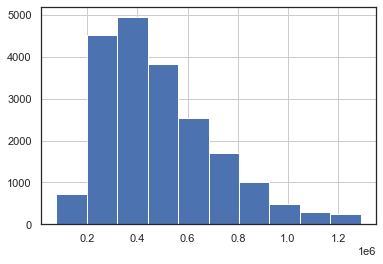

In [415]:
for i in range(80,100):
    q = i/100
    print("{} percentile: {}".format(q, df.price.quantile(q=q)))

df.price.hist()

In [416]:
df = df[df.price <= 1100000]
train, test = train_test_split(df)

# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     369.8
Date:                Wed, 10 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:08:15   Log-Likelihood:            -1.9715e+05
No. Observations:               14944   AIC:                         3.944e+05
Df Residuals:                   14881   BIC:                         3.949e+05
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4.932e+05   2363.701    208.647      0.000    4.89e+05    4.98e+05
bedrooms       2660.2246   1327.582      2.004      0.045      58.001    5262.448
bathrooms      4.023e+04   1820.226     22.100      0.000    3.67e+04    4.38e+04
floors          4.41e+04   1506.306     29.278      0.000    4.11e+04    4.71e+04
sqft_basement    68.7134      3.275     20.979      0.000      62.293      75.133
yr_built      -5.561e+04   1502.973    -37.001      0.000   -5.86e+04   -5.27e+04
sqft_living15  7.709e+04   1516.990     50.817      0.000    7.41e+04    8.01e+04
grade_13      -2.241e-10   1.45e-08     -0.015      0.988   -2.86e-08    2.81e-08
grade_3       -9.609e+04    1.3e+05     -0.738      0.460   -3.51e+05    1.59e+05
grade_4       -8.556e+04   2.94e+04     -2.911      0.004   -1.43e+05   -2.79e+04
grade_5       -6.009e+04   1.03e+04     -5.851      0.000   -8.02e+04      -4e+04
zipcode_98001  -1.82e+05   8543.494    -21.305      0.000   -1.99e+05   -1.65e+05
zipcode_98002 -1.746e+05   1.09e+04    -16.066      0.000   -1.96e+05   -1.53e+05
zipcode_98003 -1.798e+05   9361.262    -19.205      0.000   -1.98e+05   -1.61e+05
zipcode_98004  2.833e+05   1.25e+04     22.699      0.000    2.59e+05    3.08e+05
zipcode_98006  1.026e+05   7969.823     12.871      0.000     8.7e+04    1.18e+05
zipcode_98007  6.915e+04   1.32e+04      5.256      0.000    4.34e+04    9.49e+04
zipcode_98008  5.394e+04   9781.360      5.514      0.000    3.48e+04    7.31e+04
zipcode_98010 -5.675e+04   1.54e+04     -3.683      0.000   -8.69e+04   -2.66e+04
zipcode_98011 -5.432e+04   1.11e+04     -4.878      0.000   -7.62e+04   -3.25e+04
zipcode_98014 -2.739e+04   1.36e+04     -2.009      0.045   -5.41e+04    -667.306
zipcode_98019 -8.255e+04   1.16e+04     -7.104      0.000   -1.05e+05   -5.98e+04
zipcode_98024  6730.6986   1.71e+04      0.394      0.694   -2.68e+04    4.02e+04
zipcode_98027  1.187e+04   8071.969      1.471      0.141   -3951.663    2.77e+04
zipcode_98028 -6.635e+04   9392.021     -7.064      0.000   -8.48e+04   -4.79e+04
zipcode_98029  4.663e+04   9037.816      5.159      0.000    2.89e+04    6.43e+04
zipcode_98030  -1.87e+05   9504.962    -19.679      0.000   -2.06e+05   -1.68e+05
zipcode_98031 -1.901e+05   9533.826    -19.934      0.000   -2.09e+05   -1.71e+05
zipcode_98032 -1.883e+05   1.36e+04    -13.879      0.000   -2.15e+05   -1.62e+05
zipcode_98034 -6727.0215   7021.337     -0.958      0.338   -2.05e+04    7035.666
zipcode_98039  4.154e+05   6.51e+04      6.379      0.000    2.88e+05    5.43e+05
zipcode_98040  2.374e+05   1.22e+04     19.411      0.000    2.13e+05    2.61e+05
zipcode_98045 -3.778e+04   1.05e+04     -3.588      0.000   -5.84e+04   -1.71e+04
zipcode_98052  7.892e+04   6935.668     11.379      0.000    6.53e+04    9.25e+04
zipcode_98053  1.224e+05   8339.629     14.682   

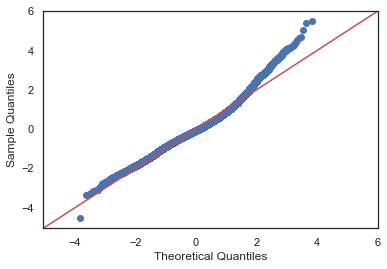

In [417]:
# Check the Normality Assumption
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

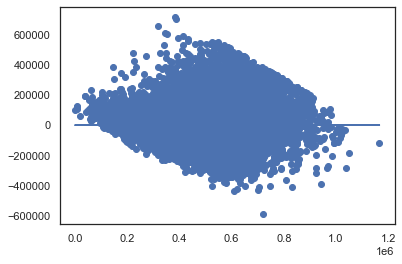

In [418]:
# Check the Homoscedasticity Assumption
# Comment: No improvement observed
plt.scatter(model.predict(train[x_cols]), model.resid)
plt.plot(model.predict(train[x_cols]), [0 for i in range(len(train))])

## Additional refinement

In [431]:
df.head()

,price,bedrooms,bathrooms,sqft_lot,floors,sqft_above,sqft_basement,yr_built,lat,long,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,221900.0,-0.279815,-1.728568,-0.389668,-0.960295,-0.754362,0.0,-0.539199,-0.353321,-122.257,...,0,0,0,0,0,0,1,0,0,0
1,538000.0,-0.279815,0.339508,-0.114277,1.007914,0.672337,400.0,-0.676360,1.157882,-122.319,...,0,0,0,0,0,0,0,0,0,0
2,180000.0,-1.714154,-1.728568,0.243703,-0.960295,-1.754058,0.0,-1.297086,1.279324,-122.233,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,0.737865,1.073170,-0.525253,-0.960295,-1.027715,910.0,-0.197520,-0.284026,-122.393,...,0,0,0,0,0,0,0,0,0,0
4,510000.0,-0.279815,0.039132,0.007193,-0.960295,0.072974,0.0,0.548094,0.408155,-122.045,...,0,0,0,0,0,0,0,0,0,0


In [434]:
df.columns = [col_formatting(col) for col in df.columns]
list(df.columns)

['price',
 'bedrooms',
 'bathrooms',
 'sqft_lot',
 'floors',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'waterfront_00',
 'waterfront_10',
 'view_00',
 'view_10',
 'view_20',
 'view_30',
 'view_40',
 'condition_1',
 'condition_2',
 'condition_3',
 'condition_4',
 'condition_5',
 'grade_10',
 'grade_11',
 'grade_12',
 'grade_13',
 'grade_3',
 'grade_4',
 'grade_5',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'zipcode_98001',
 'zipcode_98002',
 'zipcode_98003',
 'zipcode_98004',
 'zipcode_98005',
 'zipcode_98006',
 'zipcode_98007',
 'zipcode_98008',
 'zipcode_98010',
 'zipcode_98011',
 'zipcode_98014',
 'zipcode_98019',
 'zipcode_98022',
 'zipcode_98023',
 'zipcode_98024',
 'zipcode_98027',
 'zipcode_98028',
 'zipcode_98029',
 'zipcode_98030',
 'zipcode_98031',
 'zipcode_98032',
 'zipcode_98033',
 'zipcode_98034',
 'zipcode_98038',
 'zipcode_98039',
 'zipcode_98040',
 'zipcode_98042',
 'zipcode_98045',
 'zipcode_98052',
 'zipcode

In [430]:
'''
'bedrooms',
 'bathrooms',
 'sqft_lot',
 'floors',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 '''
outcome = 'price'
x_cols = ['bedrooms', 'Wheelbase', 'Weight', 'Fueltank']
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

AttributeError: module 'statsmodels.api' has no attribute 'ols'